# Starter Reference

## Base

In [ ]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
PATH = './'
TRAIN = 'data/train/'
TEST = 'data/test/'
LABELS = 'data/train.csv'
SAMPLE = 'data/sample_submission.csv'

In [3]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [4]:
arch = resnet50
nw=6

## Data

In [5]:
train_names = list({f[:36] for f in os.listdir(TRAIN)})
test_names = list({f[:36] for f in os.listdir(TEST)})
tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

In [6]:
def open_rgby(path,id): 
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [7]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [8]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO)]
    stats = A([0.00505, 0.00331, 0.00344, 0.00519], [0.10038, 0.08131, 0.08284, 0.10179])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [9]:
bs = 16
sz = 256
md = get_data(sz,bs)

x,y = next(iter(md.trn_dl))
x.shape, y.shape

(torch.Size([16, 4, 256, 256]), torch.Size([16, 28]))

## Loss Function

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [11]:
def acc(preds,targs,thresh=0.0):
    preds = (preds > thresh).int()
    targs = targs.int()
    return (preds==targs).float().mean()

## Model Functions

## Convnet Base

In [12]:
class ConvnetBuilder_custom():
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with zeros
        #####################################################
        w = layers[0].weight
        layers[0] = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
        layers[0].weight = torch.nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        #####################################################
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

    @property
    def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

    def create_fc_layer(self, ni, nf, p, actn=None):
        res=[nn.BatchNorm1d(num_features=ni)]
        if p: res.append(nn.Dropout(p=p))
        res.append(nn.Linear(in_features=ni, out_features=nf))
        if actn: res.append(actn)
        return res

    def get_fc_layers(self):
        res=[]
        ni=self.nf
        for i,nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni=nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg: final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c)==3: c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c,idxs))
        return lgs+[self.fc_model]
    
class ConvLearner(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'): return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                  needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn=cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn
    
    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        if self.fp16: return
        self.fp16 = True
        if type(self.model) != FP16: self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
    def float(self):
        if not self.fp16: return
        self.fp16 = False
        if type(self.models.model) == FP16: self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])!=len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])!=len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred

In [13]:
def get_model(md):
    learn = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
    learn.opt_fn = optim.Adam
    learn.crit = FocalLoss()
    learn.metrics = [acc]
    return learn 

# Inception v4

In [ ]:
class ConvnetBuilder_Inv4(ConvnetBuilder_custom):
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with zeros
        w = layers[0].conv.weight
        layers[0] = nn.Conv2d(4,32,kernel_size=(3,3),stride=(2,2))
        layers[0].weight = torch.nn.Parameter(torch.cat((w,torch.zeros(32,1,3,3)),dim=1))
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

In [ ]:
class InceptLearner(ConvLearner):
    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_Inv4(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

In [ ]:
def get_inceptv4(md):
    learn = InceptLearner.pretrained(inception_4, md, ps=0.5) #dropout 50%
    learn.opt_fn = optim.Adam
    learn.crit = FocalLoss()
    learn.metrics = [acc]
    return learn

# ResNet50

## Back up

In [ ]:
def my_load_pre(pre, f, fn):
    m = f()
    if pre: load_model(m, f'weights/{fn}.pth')
    return m

In [ ]:
def my_resnext50(pre): return my_load_pre(pre, resnext_50_32x4d, 'resnext_50_32x4d')

In [ ]:
class ResNextBuilder(ConvnetBuilder_custom):
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        #change this to 8 hard coded
        layers = cut_model(f(pretrained), 8)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with zeros
        w = layers[0].weight
        layers[0] = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
        layers[0].weight = torch.nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

In [ ]:
class ResNextLearner(ConvLearner):
    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ResNextBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

In [ ]:
def get_resnext50(md):
    learn = ResNextLearner.pretrained(my_resnext50, md, ps=0.5) #dropout 50%
    learn.opt_fn = optim.Adam
    learn.crit = FocalLoss()
    learn.metrics = [acc]
    return learn

## Actual

In [ ]:
def get_resnext50(md):
    learn = ConvLearner.pretrained(resnext50, md, ps=0.5) #dropout 50%
    learn.opt_fn = optim.Adam
    learn.crit = FocalLoss()
    learn.metrics = [acc]
    return learn 

## Test Model

In [14]:
sz = 512 #image size
bs = 16  #batch size

md = get_data(sz,bs)
learn = get_model(md)

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [15]:
# learn.lr_find()
# learn.sched.plot()

## Train Model

In [16]:
lr = 1e-2

In [17]:
phase = 1
learn.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [18]:
learn.fit(lrs/4,4,cycle_len=2,use_clr=(10,20), best_save_name=f'{arch}_{phase}')

epoch      trn_loss   val_loss   acc                           
    0      0.891387   0.800228   0.963045  
    1      0.735691   0.675827   0.967722                      
    2      0.793446   0.75091    0.965354                      
    3      0.719411   0.614211   0.970479                      
    4      0.764894   0.675408   0.968158                      
    5      0.659164   0.596702   0.972008                      
    6      0.762538   0.67676    0.967928                      
    7      0.632455   0.581715   0.972548                      



[0.5817154650522475, 0.9725478046802634]

In [19]:
phase = 2

In [20]:
learn.fit(lrs/4,2,cycle_len=23,use_clr=(10,20), best_save_name=f'{arch}_{phase}')

epoch      trn_loss   val_loss   acc                           
    0      0.714727   0.727787   0.966308  
    1      0.724831   0.660549   0.968986                      
    2      0.723787   0.660595   0.969009                      
    3      0.70075    0.623011   0.97041                       
    4      0.682225   0.647125   0.969687                      
    5      0.664514   0.625572   0.970479                      
    6      0.670425   0.610064   0.971732                      
    7      0.634118   0.58965    0.9721                        
    8      0.614346   0.591748   0.972065                      
    9      0.623502   0.575815   0.97218                       
    10     0.617414   0.572454   0.973329                      
    11     0.593472   0.562013   0.973915                      
    12     0.584679   0.556153   0.973502                      
    13     0.594047   0.559913   0.973548                      
    14     0.554874   0.543421   0.973846                   

[0.4935136167776017, 0.9768454665689702]

In [21]:
phase = 3

In [22]:
learn.fit(lrs/8,1,cycle_len=10,use_clr=(5,20), best_save_name=f'{arch}_{phase}')

epoch      trn_loss   val_loss   acc                           
    0      0.432474   0.50745    0.976099  
    1      0.461577   0.512838   0.976087                      
    2      0.444551   0.525572   0.976213                      
    3      0.430047   0.506457   0.97611                       
    4      0.416674   0.514185   0.976765                      
    5      0.424571   0.506176   0.976466                      
    6      0.394757   0.508665   0.976972                      
    7      0.379364   0.514699   0.977213                      
    8      0.363523   0.51059    0.977305                      
    9      0.369209   0.508859   0.977569                      



[0.5088593657566006, 0.9775694077846473]

In [36]:
phase = 4

In [37]:
learn.fit(lrs/20,1,cycle_len=5,use_clr=(5,20), best_save_name=f'{arch}_{phase}')

epoch      trn_loss   val_loss   acc                           
    0      0.369432   0.509641   0.976926  
    1      0.358003   0.529455   0.976719                      
    2      0.347245   0.517453   0.977742                      
    3      0.349706   0.525909   0.977604                      
    4      0.36438    0.512965   0.9775                        



[0.5129647924249543, 0.9775004624706745]

# ResNext50

## Setup & Data

### House Keeping

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [3]:
PATH = './'
TRAIN = 'data/train/'
TEST = 'data/test/'
LABELS = 'data/train.csv'
SAMPLE = 'data/sample_submission.csv'

In [4]:
train_names = list({f[:36] for f in os.listdir(TRAIN)})
test_names = list({f[:36] for f in os.listdir(TEST)})
tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

In [5]:
def open_rgby(path,id): 
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [6]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

### Data Objects & Functions

In [7]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [8]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO)]
    stats = A([0.00505, 0.00331, 0.00344, 0.00519], [0.10038, 0.08131, 0.08284, 0.10179])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [9]:
'''
Calculating the averages
'''

# x_tot = np.zeros(4)
# x2_tot = np.zeros(4)
# for x,y in iter(md.trn_dl):
#     tmp =  md.trn_ds.denorm(x).reshape(16,-1)
#     x = md.trn_ds.denorm(x).reshape(-1,4)
#     x_tot += x.mean(axis=0)
#     x2_tot += (x**2).mean(axis=0)

# channel_avr = x_tot/len(md.trn_dl)
# channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
# channel_avr,channel_std

'\nCalculating the averages\n'

### Loss Function

In [26]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()
    
def acc(preds,targs,thresh=0.0):
    preds = (preds > thresh).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [27]:
# class FocalLoss(nn.Module):
#     def __init__(self, num_classes=28):
#         super().__init__()
#         self.num_classes = num_classes

#     def forward(self, pred, targ):
#         t = targ
#         x = pred
#         w = self.get_weight(x,t)
#         return F.binary_cross_entropy_with_logits(x, t, w, 
#                           reduction='none')/self.num_classes
    
#     def get_weight(self,x,t):
#         alpha,gamma = 0.25,2.
#         p = x.sigmoid()
#         pt = p*t + (1-p)*(1-t)
#         w = alpha*t + (1-alpha)*(1-t)
#         return w * (1-pt).pow(gamma)

## Model

### Conv Base

In [28]:
class ConvnetBuilder_custom():
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with zeros
        #####################################################
        w = layers[0].weight
        layers[0] = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
        layers[0].weight = torch.nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        #####################################################
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

    @property
    def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

    def create_fc_layer(self, ni, nf, p, actn=None):
        res=[nn.BatchNorm1d(num_features=ni)]
        if p: res.append(nn.Dropout(p=p))
        res.append(nn.Linear(in_features=ni, out_features=nf))
        if actn: res.append(actn)
        return res

    def get_fc_layers(self):
        res=[]
        ni=self.nf
        for i,nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni=nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg: final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c)==3: c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c,idxs))
        return lgs+[self.fc_model]
    
class ConvLearner(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'): return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                  needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn=cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn
    
    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        if self.fp16: return
        self.fp16 = True
        if type(self.model) != FP16: self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
    def float(self):
        if not self.fp16: return
        self.fp16 = False
        if type(self.models.model) == FP16: self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])!=len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])!=len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred

### SE Definition

In [29]:
pretrained_settings = {
    'se_resnext50_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext101_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
}

class SEModule(nn.Module):
    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride

In [30]:
class SENet(nn.Module):
    def __init__(self, block, layers, groups, reduction, dropout_p=0.5,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)
#         self.last_linear = nn.Linear(512*16, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']

### ResNextConvBuilder

In [31]:
class ResNextConvBuilder(ConvnetBuilder_custom):
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 8,6
        cut-=xtra_cut
        layers = cut_model(f(), 5)
#         layers = cut_model(f(), 6)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with zeros
        #####################################################
        w = layers[0].conv1.weight
        layers[0].conv1 = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
        layers[0].conv1.weight = torch.nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        #####################################################
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

class ResNextConv(ConvLearner):
        @classmethod
        def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
            models = ResNextConvBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
            return cls(data, models, precompute, **kwargs)

In [32]:
def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=0.5, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [33]:
def get_resnext50_model(md):
    learn = ResNextConv.pretrained(se_resnext50_32x4d, md, ps=0.5) #dropout 50%
    learn.opt_fn = optim.Adam
    learn.crit = FocalLoss()
    learn.metrics = [acc]
    learn.clip = 0.25
    return learn 

## Test & Train

### Test

In [34]:
bs = 8
sz = 512
nw = 6
md = get_data(sz,bs)

In [161]:
# learn = get_resnext50_model(md)
# learn.unfreeze()

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


 64%|██████▍   | 2233/3495 [18:53<10:40,  1.97it/s, loss=6.53]

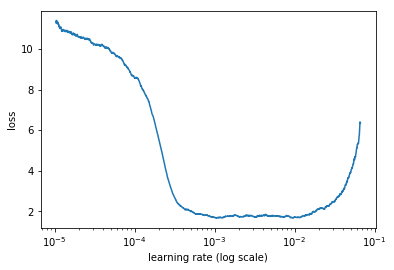

In [17]:
# learn.lr_find()
# learn.sched.plot()

  2%|▏         | 82/3495 [01:02<43:26,  1.31it/s, loss=30]    

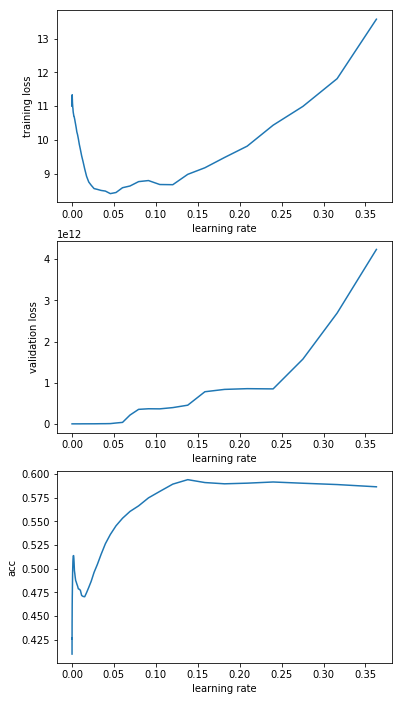

In [18]:
# learn.lr_find2()
# learn.sched.plot()

### Train

In [61]:
lr = 3e-4
lrs=np.array([lr/10,lr/3,lr])
model_id = 'SEResNext50_Mk1'

In [62]:
learn.fit(lr, 1)

epoch      trn_loss   val_loss   acc                          
    0      1.384055   1.184798   0.948302  


[1.1847979014444536, 0.9483016196211639]

In [63]:
%%time 
phase = 1
learn.unfreeze()
learn.fit(lrs/3,3,cycle_len=2,
          use_clr=(10,20), 
          best_save_name=f'{model_id}_{phase}')

epoch      trn_loss   val_loss   acc                          
    0      1.078669   0.966236   0.956725  
    1      1.059594   0.892402   0.959046                      
    2      0.935106   0.794946   0.962999                      
    3      0.911128   0.754595   0.965102                      
    4      0.828862   0.714963   0.966159                      
    5      0.769191   0.692742   0.967204                      
CPU times: user 6h 34min 25s, sys: 4h 23min 10s, total: 10h 57min 35s
Wall time: 2h 46min 56s


In [64]:
%%time 
phase = 2
learn.fit(lrs/5,2,cycle_len=23,
          use_clr=(10,20),
          best_save_name=f'{model_id}_{phase}')

epoch      trn_loss   val_loss   acc                           
    0      0.803923   0.678944   0.96802   
    1      0.783068   0.659938   0.968687                      
    2      0.751022   0.641457   0.969767                      
    3      0.719631   0.642843   0.969411                      
    4      0.768724   0.625307   0.970169                      
    5      0.720313   0.616126   0.970514                      
    6      0.683994   0.611221   0.970939                      
    7      0.677048   0.600325   0.971617                      
    8      0.664782   0.594959   0.971835                      
    9      0.638504   0.592827   0.972077                      
    10     0.647609   0.58502    0.972284                      
    11     0.696528   0.587539   0.972134                      
    12     0.654107   0.582401   0.972456                      
    13     0.667853   0.577229   0.972847                      
    14     0.597091   0.572194   0.973088                   

In [65]:
%%time 
phase = 3
learn.fit(lrs/9,1,cycle_len=8,
          use_clr=(5,20),
          best_save_name=f'{model_id}_{phase}')

epoch      trn_loss   val_loss   acc                           
    0      0.468346   0.562558   0.974203  
    1      0.431962   0.557532   0.974478                      
    2      0.449179   0.566225   0.97457                       
    3      0.445568   0.566574   0.973984                      
    4      0.445385   0.568733   0.974271                      
    5      0.449579   0.570855   0.974134                      
    6      0.409382   0.571065   0.974157                      
    7      0.435574   0.557584   0.974478                      
CPU times: user 8h 47min 8s, sys: 5h 53min 29s, total: 14h 40min 38s
Wall time: 3h 42min 44s


In [66]:
%%time 
phase = 4
learn.fit(lrs/18,1,cycle_len=5,
          use_clr=(5,20),
          best_save_name=f'{model_id}_{phase}')

epoch      trn_loss   val_loss   acc                           
    0      0.417849   0.576096   0.974271  
    1      0.435696   0.574954   0.974375                      
    2      0.413814   0.568115   0.974421                      
    3      0.438606   0.582702   0.97418                       
    4      0.421163   0.572526   0.974421                      
CPU times: user 5h 29min 37s, sys: 3h 40min 41s, total: 9h 10min 19s
Wall time: 2h 18min 37s


In [67]:
learn.save(f'{model_id}_final')

### Stratified KFolds

In [35]:
from sklearn.model_selection import StratifiedKFold

folds = 3
train_folds = []
val_folds = []

In [36]:
def make_folds():
    skf = StratifiedKFold(n_splits=folds, random_state=1234, shuffle=True)
    
    train_names = list({f[:36] for f in os.listdir(TRAIN)})
    test_names = list({f[:36] for f in os.listdir(TEST)})
    trn_df = pd.read_csv('data/train.csv')
    
    for train_index, evaluate_index in skf.split(trn_df.index.values, trn_df.Target):
        trn_value = trn_df.iloc[train_index]
        val_value = trn_df.iloc[evaluate_index]
        train_folds.append(trn_value)
        val_folds.append(val_value)
        print(train_index.shape, evaluate_index.shape)
    
    for i in range(folds):
        train_folds[i].to_csv(f'trn_folds_{i}')
        val_folds[i].to_csv(f'val_folds_{i}')

def load_folds():
    for i in range(folds):
        train_folds.append(pd.read_csv(f'trn_folds_{i}'))
        val_folds.append(pd.read_csv(f'val_folds_{i}'))

In [37]:
# make_folds()
load_folds()

In [38]:
def get_fold(sz, bs, k):
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    
    stats = A([0.00505, 0.00331, 0.00344, 0.00519], [0.10038, 0.08131, 0.08284, 0.10179])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    
    trn_x = list(train_folds[k]['Id'])
    val_x = list(val_folds[k]['Id'])
    
    ds = ImageData.get_ds(pdFilesDataset, (trn_x[:-(len(trn_x)%bs)],TRAIN), 
                (val_x,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [62]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])

def make_prediction():
    preds,y = learn.TTA(is_test=True)
    preds = np.stack(preds, axis=-1)
    preds = sigmoid_np(preds)
    pred = preds.max(axis=-1)
    return pred

def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learn.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

In [41]:
lr = 3e-4
lrs=np.array([lr/10,lr/3,lr])
epochs=60
wd=1e-4

### CHANGE THIS BACK TO FOLDS

In [45]:
# #CHANGE THIS BACK TO FOLDS!!!!!!!!!!!
# for k in range(1,folds):
#     print(f'Fold: {k+1}')
#     md = get_fold(sz,bs,k)
#     learn = get_resnext50_model(md)
#     learn.fit(lr, 1, cycle_len=3, wds=1e-7, 
#               use_wd_sched=True, 
#               use_clr_beta=(10, 10, 0.95, 0.85))
    
#     learn.unfreeze()
    
#     phase=2
    
#     learn.fit(lrs, 1, cycle_len=epochs, wds=wd, 
#               use_wd_sched=True, use_clr_beta=(10, 10, 0.95, 0.85),
#               best_save_name=f'SEResNext50_{k}_{phase}')
    
#     pred = make_prediction()
#     save_pred(pred, th_t, fname=f'protein_class_{k}')
    
#     learn.save(f'SEResNext50_{k}_final')

Fold: 2


/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


  7%|▋         | 190/2588 [00:57<12:02,  3.32it/s, loss=10.2]

KeyboardInterrupt: 

In [47]:
for k in range(folds):
    print(f'Fold: {k+1}')
    md = get_fold(sz,bs,k)
    learn = get_resnext50_model(md)
    learn.load(f'SEResNext50_0_2')

    learn.fit(lr, 1, cycle_len=10, wds=1e-7, 
          use_wd_sched=True, 
          use_clr_beta=(10, 10, 0.95, 0.85))
    
    phase=1
    learn.fit(lrs/4,4,
              cycle_len=3,use_clr=(10,20), 
              best_save_name=f'SEResNext50_{k}_{phase}_cylic')
    
    phase=2
    learn.fit(lrs/4,2,
              cycle_len=6,use_clr=(10,20),
              best_save_name=f'SEResNext50_{k}_{phase}_cylic')
    
    phase=3
    learn.fit(lrs/16,1,
              cycle_len=9,use_clr=(5,20),
              best_save_name=f'SEResNext50_{k}_{phase}_cylic')
    
    pred = make_prediction()
    save_pred(pred, th_t, fname=f'protein_class_{k}')
    
    learn.save(f'SEResNext50_{k}_{phase}_final')

Fold: 1


/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   acc                           
    0      0.708683   0.688416   0.968507  
    1      0.701281   0.67175    0.968997                      
    2      0.702024   0.670381   0.969301                      
    3      0.723029   0.66552    0.969825                      
    4      0.676484   0.664217   0.969301                      
    5      0.672372   0.652564   0.969913                      
    6      0.63114    0.651776   0.970126                      
    7      0.660796   0.645201   0.970224                      
    8      0.603924   0.648501   0.970065                      
    9      0.682439   0.645595   0.970194                      


epoch      trn_loss   val_loss   acc                           
    0      0.661653   0.644687   0.970204  
    1      0.651977   0.646255   0.96971                       
    2      0.626746   0.641681   0.969967                      
    3      0.626203   0.640765   0.970363                      
    4      0.647354   0.644649   0.970001                      
    5      0.617247   0.642343   0.97016                       
    6      0.635979   0.641148   0.97014                       
    7      0.651673   0.639772   0.970352                      
    8      0.612374   0.638036   0.970288                      
    9      0.643237   0.640806   0.970471                      
    10     0.665701   0.64033    0.970366                      
    11     0.63378    0.636745   0.970464                      


epoch      trn_loss   val_loss   acc                           
    0      0.631731   0.634139   0.970275  
    1      0.652811   0.636452   0.9704                        
    2      0.623109   0.648265   0.97041                       
    3      0.595712   0.64267    0.970275                      
    4      0.648243   0.641561   0.970478                      
    5      0.620362   0.636634   0.970363                      
    6      0.641006   0.635967   0.970342                      
    7      0.590809   0.635668   0.970312                      
    8      0.64267    0.638516   0.970423                      
    9      0.601674   0.631897   0.97043                       
    10     0.617109   0.639105   0.970488                      
    11     0.578321   0.637812   0.97068                       


epoch      trn_loss   val_loss   acc                           
    0      0.624135   0.64154    0.970745  
    1      0.614767   0.635468   0.970592                      
    2      0.601883   0.638803   0.970464                      
    3      0.612241   0.633846   0.970724                      
    4      0.661467   0.637457   0.970667                      
    5      0.627133   0.635731   0.970444                      
    6      0.653279   0.633895   0.970231                      
    7      0.612823   0.633962   0.970592                      
    8      0.614174   0.639119   0.970305                      


NameError: name 'learner' is not defined

In [60]:
k = 1
md = get_fold(sz,bs,k)
learn = get_resnext50_model(md)
learn.load(f'SEResNext50_0_2')

learn.fit(lr, 1, cycle_len=3, wds=1e-7, 
      use_wd_sched=True, 
      use_clr_beta=(10, 10, 0.95, 0.85))

phase=1
learn.fit(lrs/4,4,
          cycle_len=3,use_clr=(10,20), 
          best_save_name=f'SEResNext50_{k}_{phase}_cylic')

phase=2
learn.fit(lrs/4,2,
          cycle_len=9,use_clr=(10,20),
          best_save_name=f'SEResNext50_{k}_{phase}_cylic')

phase=3
learn.fit(lrs/16,1,
          cycle_len=9,use_clr=(5,20),
          best_save_name=f'SEResNext50_{k}_{phase}_cylic')

pred = make_prediction()
save_pred(pred, th_t, fname=f'protein_class_{k}.csv')

learn.save(f'SEResNext50_{k}_{phase}_final')

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   acc                           
    0      0.690399   0.644341   0.96982   
    1      0.677506   0.626919   0.970795                      
    2      0.696944   0.617971   0.971071                      


epoch      trn_loss   val_loss   acc                           
    0      0.695288   0.612037   0.971474  
    1      0.655692   0.611929   0.971347                      
    2      0.682721   0.600307   0.971798                      
    3      0.728619   0.601302   0.971602                      
    4      0.69491    0.596661   0.972032                      
    5      0.647442   0.602972   0.97165                       
    6      0.658217   0.60524    0.971278                      
    7      0.689975   0.59892    0.971826                      
    8      0.696156   0.595936   0.971781                      
    9      0.691441   0.598844   0.971898                      
    10     0.675263   0.599668   0.971881                      
    11     0.659693   0.593455   0.972029                      


epoch      trn_loss   val_loss   acc                           
    0      0.690898   0.594015   0.971801  
    1      0.688713   0.592242   0.972077                      
    2      0.665784   0.594244   0.972056                      
    3      0.644583   0.591885   0.971936                      
    4      0.667377   0.591405   0.971977                      
    5      0.664288   0.589727   0.971674                      
    6      0.665024   0.592484   0.971788                      
    7      0.652159   0.594615   0.971801                      
    8      0.652922   0.59333    0.971677                      
    9      0.663346   0.588364   0.972098                      
    10     0.630202   0.590772   0.972032                      
    11     0.648189   0.589787   0.972022                      
    12     0.676139   0.591582   0.971826                      
    13     0.648723   0.587968   0.972053                      
    14     0.637731   0.590833   0.972239                   

epoch      trn_loss   val_loss   acc                           
    0      0.651425   0.581      0.972501  
    1      0.680418   0.589852   0.972163                      
    2      0.647631   0.588831   0.972187                      
    3      0.661833   0.585191   0.971753                      
    4      0.642752   0.583434   0.97228                       
    5      0.655927   0.583674   0.972022                      
    6      0.664876   0.584974   0.972139                      
    7      0.643492   0.591691   0.971839                      
    8      0.677545   0.585221   0.971915                      


In [61]:
k = 2
md = get_fold(sz,bs,k)
learn = get_resnext50_model(md)
learn.load(f'SEResNext50_0_2')

learn.fit(lr, 1, cycle_len=10, wds=1e-7, 
      use_wd_sched=True, 
      use_clr_beta=(10, 10, 0.95, 0.85))

phase=1
learn.fit(lrs/4,4,
          cycle_len=3,use_clr=(10,20), 
          best_save_name=f'SEResNext50_{k}_{phase}_cylic')

phase=2
learn.fit(lrs/4,2,
          cycle_len=6,use_clr=(10,20),
          best_save_name=f'SEResNext50_{k}_{phase}_cylic')

phase=3
learn.fit(lrs/16,1,
          cycle_len=9,use_clr=(5,20),
          best_save_name=f'SEResNext50_{k}_{phase}_cylic')

pred = make_prediction()
save_pred(pred, th_t, fname=f'protein_class_{k}.csv')

learn.save(f'SEResNext50_{k}_{phase}_final')

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   acc                           
    0      0.761065   0.622297   0.970938  
    1      0.758715   0.606254   0.971509                      
    2      0.720551   0.603033   0.971822                      
    3      0.723014   0.602866   0.971991                      
    4      0.730249   0.600643   0.97141                       
    5      0.708055   0.584863   0.972653                      
    6      0.741488   0.584287   0.972368                      
    7      0.688735   0.581421   0.972636                      
    8      0.722914   0.577533   0.972601                      
    9      0.665531   0.583123   0.972182                      


epoch      trn_loss   val_loss   acc                           
    0      0.704405   0.577783   0.972823  
    1      0.701424   0.573068   0.972742                      
    2      0.655243   0.570751   0.973132                      
    3      0.673378   0.574082   0.972985                      
    4      0.656189   0.58247    0.972858                      
    5      0.676121   0.573113   0.972815                      
    6      0.656515   0.576367   0.972911                      
    7      0.679499   0.574191   0.973034                      
    8      0.643987   0.569432   0.972999                      
    9      0.62719    0.571271   0.972999                      
    10     0.666447   0.568745   0.97302                       
    11     0.631027   0.568487   0.97328                       


epoch      trn_loss   val_loss   acc                           
    0      0.647338   0.568972   0.972844  
    1      0.669681   0.569243   0.97272                       
    2      0.658452   0.57482    0.97265                       
    3      0.635363   0.568029   0.973178                      
    4      0.655082   0.572341   0.973161                      
    5      0.67288    0.565687   0.973432                      
    6      0.654757   0.570893   0.97278                       
    7      0.659133   0.567313   0.973284                      
    8      0.692987   0.571273   0.973055                      
    9      0.6652     0.572821   0.972893                      
    10     0.648255   0.574641   0.972798                      
    11     0.655446   0.566681   0.973016                      


epoch      trn_loss   val_loss   acc                           
    0      0.654666   0.568369   0.973111  
    1      0.640458   0.567117   0.973245                      
    2      0.659919   0.564301   0.973238                      
    3      0.6601     0.570541   0.972981                      
    4      0.687968   0.568847   0.972977                      
    5      0.655544   0.57377    0.972565                      
    6      0.632384   0.571387   0.973041                      
    7      0.647734   0.564062   0.973259                      
    8      0.677736   0.568093   0.973041                      


In [68]:
for k in range(folds):
    print(f'Fold: {k}')
    md = get_fold(sz,bs,k)
    learn = get_resnext50_model(md)
    learn.load(f'SEResNext50_{k}_3_final')
    learn.unfreeze()
    
    phase=4
    learn.fit(lrs,2,
              cycle_len=9,use_clr=(10,20),
              best_save_name=f'SEResNext50_{k}_{phase}_cylic')
    
    phase=5
    learn.fit(lrs/8,2,
              cycle_len=9,use_clr=(5,20),
              best_save_name=f'SEResNext50_{k}_{phase}_cylic')
    
    pred = make_prediction()
    save_pred(pred, th_t, fname=f'protein_class_{k}.csv')
    
    learn.save(f'SEResNext50_{k}_{phase}_final')

Fold: 0


/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


FileNotFoundError: [Errno 2] No such file or directory: './models/SEResNext50_0_3_final.h5'

In [65]:
learn.load(f'SEResNext50_2_3_final')

In [66]:
pred = make_prediction()
save_pred(pred, th_t, fname=f'protein_class_{k}.csv')

# Validation Score

In [ ]:
import scipy.optimize as opt

In [69]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learn.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [70]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [71]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

Thresholds:  [0.67447 0.77441 0.6432  0.71032 0.7633  0.58246 0.59099 0.61067 0.59715 0.83648 0.47122 0.71517 0.73005
 0.91396 0.72482 0.44042 0.88081 0.75626 0.519   0.60685 0.80563 0.61776 0.75221 0.76512 0.74962 0.60664
 0.71887 0.63454]
F1 macro:  0.7140915172064203
F1 macro (th = 0.5):  0.6832496715576231
F1 micro:  0.7769354338697405


In [72]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

Fractions:  [0.43182 0.04031 0.11328 0.04902 0.05763 0.08668 0.0318  0.08782 0.00265 0.00104 0.00104 0.0318  0.02347
 0.01722 0.037   0.00123 0.0158  0.00823 0.03341 0.04325 0.00729 0.12416 0.02697 0.0987  0.00833 0.30803
 0.01306 0.00028]
Fractions (true):  [0.41355 0.04154 0.11772 0.05139 0.06057 0.08167 0.03322 0.09217 0.00199 0.00151 0.00095 0.03615 0.02423
 0.01845 0.03511 0.00076 0.01902 0.00757 0.03    0.04902 0.00577 0.12321 0.02725 0.09577 0.01107 0.26517
 0.01107 0.00066]


# Submission

In [73]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Fractions:  [0.46804 0.04478 0.09306 0.03786 0.05264 0.0746  0.02991 0.07375 0.00154 0.00111 0.00051 0.03717 0.03179
 0.0282  0.05042 0.00009 0.03837 0.02239 0.02589 0.03965 0.00667 0.15023 0.03076 0.11152 0.00872 0.35208
 0.02042 0.00077]


In [74]:
preds_t,y_t = learn.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1)

In [75]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

In [76]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [77]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

Thresholds:  [0.80374 0.49925 0.76483 0.21822 0.24233 0.49543 0.26365 0.54937 0.10824 0.1054  0.1     0.42081 0.25919
 0.89889 0.77842 0.1     0.69168 0.86501 0.56459 0.292   0.35843 0.70467 0.5345  0.81766 0.45866 0.80764
 0.27445 0.1    ]
Fractions:  [0.36361 0.04384 0.07546 0.05871 0.07426 0.0752  0.0435  0.07503 0.00461 0.00419 0.00171 0.04392 0.04341
 0.01461 0.04384 0.00205 0.0288  0.01461 0.02888 0.05922 0.01008 0.1269  0.02888 0.0758  0.01    0.22466
 0.0288  0.00137]
Fractions (th = 0.5):  [0.52777 0.04384 0.11571 0.0382  0.04974 0.07469 0.02512 0.08067 0.00162 0.00103 0.00068 0.03991 0.02863
 0.0282  0.05461 0.00009 0.03863 0.02495 0.03179 0.04187 0.00795 0.17886 0.02991 0.1275  0.00974 0.41386
 0.01846 0.00009]


In [78]:
save_pred(pred_t,th_t,'protein_classification_f.csv')

In [79]:
save_pred(pred_t,th,'protein_classification_v.csv')
save_pred(pred_t,0.5,'protein_classification_05.csv')

In [80]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_c.csv')

In [81]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([12885.,  1254.,  3621.,  1561.,  1858.,  2513.,  1008.,  2822.,    53.,    45.,    28.,  1093.,
          688.,   537.,  1066.,    21.,   530.,   210.,   902.,  1482.,   172.,  3777.,   802.,  2965.,
          322.,  8228.,   328.,    11.]),
 array([0.41468, 0.04036, 0.11654, 0.05024, 0.0598 , 0.08088, 0.03244, 0.09082, 0.00171, 0.00145, 0.0009 ,
        0.03518, 0.02214, 0.01728, 0.03431, 0.00068, 0.01706, 0.00676, 0.02903, 0.0477 , 0.00554, 0.12156,
        0.02581, 0.09542, 0.01036, 0.2648 , 0.01056, 0.00035]))

In [82]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')

Thresholds:  [0.7347  0.56408 0.50024 0.30176 0.36257 0.45713 0.37413 0.41914 0.50788 0.35831 0.2295  0.57945 0.64883
 0.80423 0.91007 0.24861 0.91427 0.97507 0.55993 0.41841 0.70555 0.72181 0.60697 0.7074  0.41463 0.76006
 0.84881 0.27531]
Fractions:  [0.41736 0.04008 0.11562 0.04982 0.05931 0.08041 0.0317  0.09075 0.00162 0.00137 0.00085 0.03512 0.02196
 0.01718 0.03563 0.0006  0.01718 0.00829 0.02897 0.0482  0.00547 0.12177 0.02615 0.0958  0.01025 0.26782
 0.01051 0.00034]


# Multiple Folds Submission

In [70]:
pred_array = np.zeros((11702, 28),dtype=float)

for k in range(folds):
    learn.load(f'SEResNext50_{k}_3_cylic')
    preds_t,y_t = learn.TTA(n_aug=16, is_test=True)
    preds_t = np.stack(preds_t, axis=-1)
    preds_t = sigmoid_np(preds_t)
    pred_t = preds_t.max(axis=-1)
    pred_array = pred_t + pred_array

pred_array = pred_array / folds

In [71]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
(pred_array > th_t).mean(axis=0)

array([0.40326, 0.04375, 0.06888, 0.0705 , 0.08067, 0.10144, 0.05486, 0.0899 , 0.00094, 0.00043, 0.00034,
       0.0482 , 0.04486, 0.01863, 0.04102, 0.     , 0.03598, 0.01752, 0.02239, 0.06614, 0.00461, 0.11451,
       0.03222, 0.09434, 0.0153 , 0.19458, 0.03247, 0.01213])

In [72]:
save_pred(pred_array,th_t,'protein_classification_mfolds.csv')

In [40]:
# pred_list = []
# for line in pred_array:
#     s = ' '.join(list([str(i) for i in np.nonzero(line>th_t)[0]]))
#     pred_list.append(s)

In [41]:
# sample_df = pd.read_csv(SAMPLE)
# sample_list = list(sample_df.Id)
# pred_dic = dict((key, value) for (key, value) 
#                 in zip(learn.data.test_ds.fnames,pred_list))
# pred_list_cor = [pred_dic[id] for id in sample_list]
# df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
# df.to_csv('protein_classification.csv', header=True, index=False)

# Notes

ResNet50 (pretrained)
1. lr=1e-2
1. learn.fit(lrs/4,4,cycle_len=2,use_clr=(10,20), best_save_name=f'{arch}_{phase}')
1. learn.fit(lrs/4,2,cycle_len=23,use_clr=(10,20), best_save_name=f'{arch}_{phase}')
1. learn.fit(lrs/8,1,cycle_len=10,use_clr=(5,20), best_save_name=f'{arch}_{phase}')

LB Score: 0.50 (modelname:<function resnet50 at 0x7f41f50d3400> _3), 

Resnet50 - 0.7056019664330974 0.6823389611938516, LB:0.503

SEResNext50
1. lr=1e-4

#### Other ideas
1. Set gradient clipping to 1.0 instead of 0.25
1. Try another Focal Loss implementation
1. Increase batch size - bs=8 so far means 7GB

In [ ]:
class FocalLoss(nn.Module):
    def _init_(self, num_classes=28):
        super()._init_()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = targ
        x = pred
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, 
                          size_average=False)/self.num_classes
    
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)